In [76]:
import numpy as np
import matplotlib.pyplot as plt

# CSE910 HW2
Jeremy Arsenault
***********************

### Simulation Setup:

In [77]:
# bit generation
def generate_bits(n):
    return np.random.randint(0,2,n)
generate_bits(16)

array([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1])

In [78]:
# modulation / demodulation
def get_mod_map(mod_order):
    n = int(np.sqrt(mod_order))
    m = []
    for i in range(mod_order):
        m.append([ (i//n - (n-1)/2) + 1j*(i%n - (n-1)/2)])
    m = np.array(m)
    m /= np.linalg.norm(m, axis=-1).mean() # scale power
    return m.flatten()

def bits_to_complex(bits, mod_order):
    b = int(np.log2(mod_order))
    bits = bits.reshape((-1, b))
    inds = (bits * np.power(2, np.arange(b))).sum(axis=-1).astype(int)
    return get_mod_map(mod_order)[inds]
    
def complex_to_bits(nums, mod_order):
    b = int(np.log2(mod_order))
    dists = np.absolute(np.repeat(nums, mod_order).reshape((-1, mod_order)) - get_mod_map(mod_order))
    inds = np.argmin(dists, axis=-1)
    pows = np.power(2, np.arange(b))
    inds = np.tile(inds.reshape(-1,1), (b))
    return ((inds // pows) % 2).flatten()

a = generate_bits(16)
b = bits_to_complex(a, 16)
c = complex_to_bits(b, 16)
a, b, c

(array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]),
 array([-1.00155161-1.00155161j, -0.33385054+0.33385054j,
         0.33385054-0.33385054j,  1.00155161-1.00155161j]),
 array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]))

In [79]:
# fft/ifft and cp handling / symbol alignment
# note: using correlative symbol alignment in symbol_to_nums
def nums_to_symbol(nums, cp_len):
    s = np.fft.ifft(nums)
    return np.hstack([s[-cp_len:],s])

def symbol_to_nums(symbol, cp_len):
    # fft and rescaling
    return np.fft.fft(symbol[cp_len:])

a = generate_bits(32)
b = bits_to_complex(a, 16)
c = nums_to_symbol(b, 2)
d = symbol_to_nums(c, 2)
e = complex_to_bits(d, 16)
a[:16], e[:16]

(array([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]),
 array([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]))

0.0 [0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0] [0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0]


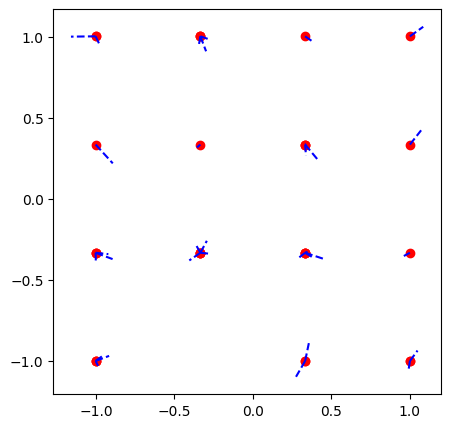

In [80]:
# simulate channel
def channel(symbol, snr, tap_delays, tap_coef):
    l = len(symbol)+max(tap_delays)
    s = (np.random.randn(l) +1j*np.random.randn(l) )/(10**(snr/10)) # took forever to realize I was missing dB conversion >:(
    for t,c in zip(tap_delays, tap_coef):
        s[t:t+len(symbol)] += c * symbol
    return s

a = generate_bits(128)
b = bits_to_complex(a, 16)
c = nums_to_symbol(b, 8)
d = channel(c, 20, [0,], [1,])
e = symbol_to_nums(d, 8)
f = complex_to_bits(e, 16)

print(np.mean(np.absolute(a-f)),a[:16],f[:16])

fig, ax = plt.subplots(figsize=(5,5))

for x,y in zip(b,e):
    ax.plot([x.real, y.real], [x.imag,y.imag], color='blue', linestyle="--")
ax.scatter(b.real, b.imag, color='red')

plt.show()

0.0 [0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1] [0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1]


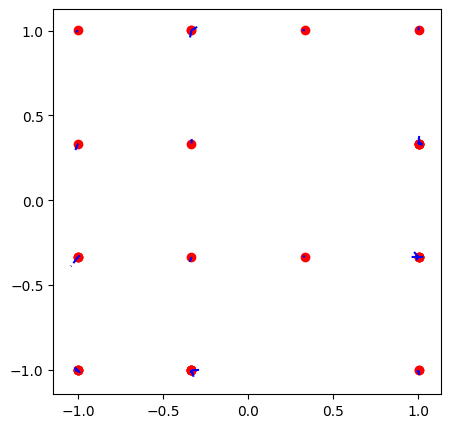

In [161]:
def channel_estimate(ref_symbol, rec_symbol):
    h = ref_symbol / rec_symbol
    return h
    
def equalize(symbol, h):
    return symbol*h

# 
def corr_alignment(seq, symbol_len, cp_len):
    n = int(symbol_len / 2)
    corrs = []
    for i in range(cp_len, len(seq)-symbol_len+1):
        c = np.corrcoef(np.absolute(seq[i:i+n]), np.absolute(seq[i+n:i+2*n]))
        corrs.append(c[0,1])
    t = np.argmax(corrs)
    print(corrs)
    print(t)
    return seq[t:t+symbol_len+cp_len]

def fft_alignment(seq, symbol_len, cp_len):
    n = int(symbol_len / 2)
    sims = []
    for i in range(cp_len, len(seq)-symbol_len+1):
        c = np.absolute(np.fft.fft(seq[i:i+n]) - np.fft.fft(np.absolute(seq[i+n:i+2*n]))).sum()
        sims.append(c)
    t = np.argmin(sims)
    print(t)
    return seq[t:t+symbol_len+cp_len]

def determ_alignment(seq, symbol_len, cp_len, n=0):
    return seq[n:symbol_len+cp_len+n]

a, a0 = generate_bits(128), generate_bits(128)
b, b0 = bits_to_complex(a, 16), bits_to_complex(a0, 16)
c, c0 = nums_to_symbol(b, 8), nums_to_symbol(b0, 8)
d, d0 = channel(c, 25, [1,5], [1+.01j, 0.02+0.01j]), channel(c0, 30, [1,5], [1+.01j, 0.02+0.01j])
# d, d0 = corr_alignment(d, 32, 8), corr_alignment(d0, 32, 8)
# d, d0 = fft_alignment(d, 32, 8), fft_alignment(d0, 32, 8)
d, d0 = determ_alignment(d, 32, 8), determ_alignment(d0, 32, 8)
e, e0 = symbol_to_nums(d, 8), symbol_to_nums(d0, 8)
f = equalize(e, channel_estimate(b0, e0))
h = complex_to_bits(f, 16)

print(np.mean(np.absolute(a-h)),a[:16],h[:16])

fig, ax = plt.subplots(figsize=(5,5))

for x,y in zip(b,f):
    ax.plot([x.real, y.real], [x.imag,y.imag], color='blue', linestyle="--")
ax.scatter(b.real, b.imag, color='red')

plt.show()

In [162]:
# put it all together
# note: we can choose fz such that sample rate = subcarrier spacing. This means bw, sr... don't matter.
def simulate(
        iterations,
        snr,
        mod_order,
        fft_sz,
        cp_len,
        tap_delays,
        tap_coefs,
    ):
    """simulate and return monte carlo estimate of mean ber"""
    # validate input
    assert np.log2(mod_order)%1 == 0
    assert np.sqrt(mod_order)%1 == 0
    
    # simulate
    ber = 0
    for i in range(iterations):
        # channel estimation
        if i % 10==0:
            a = generate_bits(int(fft_sz * np.log2(mod_order)))
            b = bits_to_complex(a, mod_order)
            c = nums_to_symbol(b, cp_len)
            d = channel(c, snr, tap_delays, tap_coefs)
            d = determ_alignment(d, len(b), cp_len)
            e = symbol_to_nums(d, cp_len)
            H = channel_estimate(b,e)
        
        # bit generation
        a = generate_bits(int(fft_sz * np.log2(mod_order)))
        b = bits_to_complex(a, mod_order)
        c = nums_to_symbol(b, cp_len)
        d = channel(c, snr, tap_delays, tap_coefs)
        d = determ_alignment(d, len(b), cp_len)
        e = symbol_to_nums(d, cp_len)
        f = equalize(e, H)
        g = complex_to_bits(f, mod_order)
        ber += np.mean(np.absolute(a-g)) / iterations
    return ber

### Problem 1:

In [163]:
i = 5000

snrs = np.arange(2,32,2)
mod_orders = [4,16,64]
fft_sz = 64
cp_len = 16
tap_delays = [2, 8, 12]
tap_coefs = [0.3+1j, 0.12+0.5j, 0.3 + 0.07j]

bers = []
for mod_order in mod_orders:
    ber = []
    for snr in snrs:
        ber.append(simulate(int(i/np.log2(mod_order)), snr, mod_order, fft_sz, cp_len, tap_delays, tap_coefs))
    bers.append(ber)

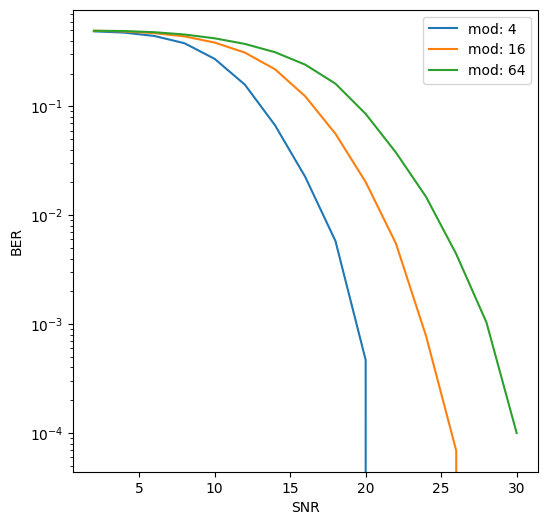

In [167]:
fig, ax = plt.subplots(figsize=(6,6))

for mod_ord, hist in zip(mod_orders, bers):
    plt.plot(snrs, hist, label=f'mod: {mod_ord}')
    
ax.set_xlabel('SNR')
ax.set_ylabel('BER')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()
plt.show()

### Problem 2:

In [40]:
i = 5000

snrs = np.arange(2,32,2)
mod_orders = [4,16,64]
fft_sz = 2048
cp_len = 144
tap_delays = [10, 36, 78]
tap_coefs = [.3+1j, 0.12+0.5j,0.3 + 0.07j]

bers = []
for mod_order in mod_orders:
    ber = []
    for snr in snrs:
        ber.append(simulate(int(i/np.log2(mod_order)), snr, mod_order, fft_sz, cp_len, tap_delays, tap_coefs))
    bers.append(ber)

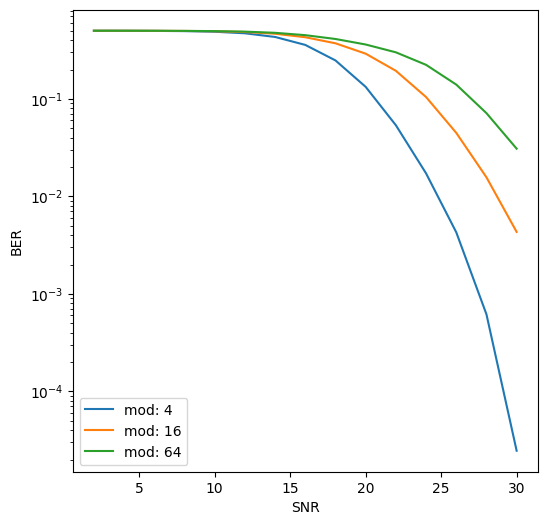

In [41]:
fig, ax = plt.subplots(figsize=(6,6))

for mod_ord, hist in zip(mod_orders, bers):
    plt.plot(snrs, hist, label=f'mod: {mod_ord}')
    
ax.set_xlabel('SNR')
ax.set_ylabel('BER')
ax.set_yscale('log')
ax.legend()
plt.show()

### Problem 3 (Write up):

Like the homework showed, lower modulation order means lower ber, and higher SNR gives lower ber. I don't immediately see the exact nature of the relationship.

I left sample rate and bandwidth params out because they don't affect simulation - since we can choose fz such that sample rate = subcarrier spacing.

I feel that my implementation of 'chanel tap' (distortion for each path?) may have been incorrect. I implemented the channel distortion as complex multpiplication, so by definition of DFT it follows that $H_n$ is the same for each subcarrier $n$. In the homework instructions it shows "channel estimation for each subcarrier" which suggests that I did something wrong. Nonetheless, I believe my channel estimation and equilization should work even if the channel were simulated differently.

My (single tap?) equalization ended up (perhaps incorrectly) compensating for time alignment / delay in the first message sent. I tried implementing a couple correlative naieve time-alignment modules, but neither worked well and any misalignment of the reference and actual sequence caused my channel estimation to be terrible. I still don't understand why demodulation works so well when the symbol is 'left shifted' a few samples, and so poorly when 'right shifted' any frames at all.